# Wine Data Set

Abstract: Using chemical analysis determine the origin of wines   

Source: https://archive.ics.uci.edu/ml/datasets/Wine

## P.C.A with Logistic Regression

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
                     header=None)
columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity',  'Magnesium', 'Total phenols', 
        'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
        'OD280/OD315 of diluted wines', 'Proline']
dataset.columns = columns

print('Shape: ', dataset.shape, end='\n\n')
print(dataset.head(10))

Shape:  (178, 14)

   Class  Alcohol  Malic acid   Ash  Alcalinity  Magnesium  Total phenols  \
0      1    14.23        1.71  2.43        15.6        127           2.80   
1      1    13.20        1.78  2.14        11.2        100           2.65   
2      1    13.16        2.36  2.67        18.6        101           2.80   
3      1    14.37        1.95  2.50        16.8        113           3.85   
4      1    13.24        2.59  2.87        21.0        118           2.80   
5      1    14.20        1.76  2.45        15.2        112           3.27   
6      1    14.39        1.87  2.45        14.6         96           2.50   
7      1    14.06        2.15  2.61        17.6        121           2.60   
8      1    14.83        1.64  2.17        14.0         97           2.80   
9      1    13.86        1.35  2.27        16.0         98           2.98   

   Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue  \
0        3.06                  0.28             2.29  

In [2]:
# Normalized occurence of each class in dataset
dataset.Class.value_counts(normalize=True)

2    0.398876
1    0.331461
3    0.269663
Name: Class, dtype: float64

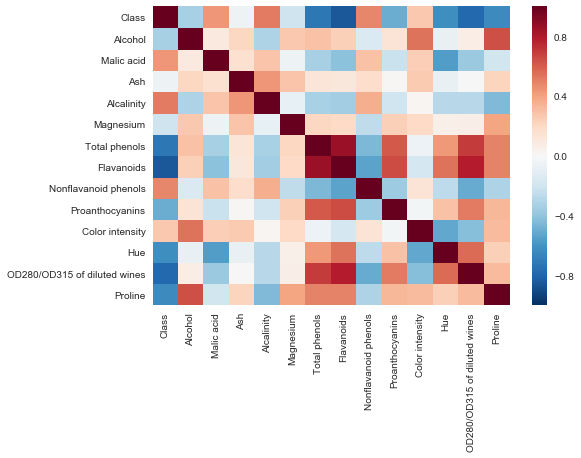

In [3]:
# Visualise correlation
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(dataset.corr())
plt.show()

In [4]:
# Apply P.C.A with Two Components
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Y = dataset.iloc[:, 0].values
X = dataset.iloc[:, 1:].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_std)

print('Variance Explained Per Principal Component: ', pca.explained_variance_ratio_, end='\n\n')
print('Total Variance Explained: ', np.sum(pca.explained_variance_ratio_), end='\n\n')

Variance Explained Per Principal Component:  [ 0.37329648  0.18818926]

Total Variance Explained:  0.561485738301



In [5]:
# Train with Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_pca, Y_train)
score = logistic.score(X_train_pca, Y_train)

print('Training Accuracy: ', score)

Training Accuracy:  0.967741935484


In [6]:
# Naive Model Accuracy
naive = LogisticRegression()

naive.fit(X_train, Y_train)
naive.score(X_train, Y_train)

0.9838709677419355

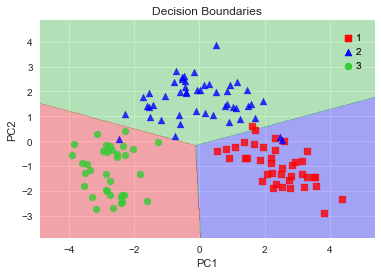

In [7]:
# Plot Classication Decision Regions
%matplotlib inline
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_train_pca, Y_train, clf=logistic)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Boundaries')
plt.show()

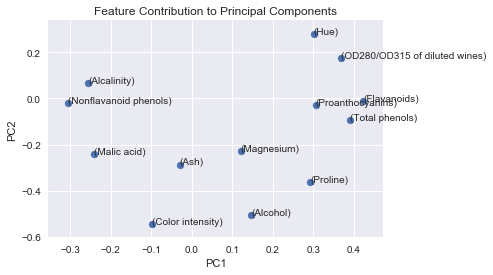

In [8]:
# Plot Features Contribution to Principal Components
plt.scatter(pca.components_.T[:,0], pca.components_.T[:,1])
plt.title('Feature Contribution to Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i, xy in enumerate(pca.components_.T):
    plt.annotate('(%s)' % columns[i+1], xy=xy, textcoords='data')
plt.show()

In [9]:
# Comparison Vs Accuracy of Pairs of Features
from itertools import combinations

accuracy = []
for i in combinations([i for i in range(0, 13)], r=2):
    logistic.fit(X_train[:, i], Y_train)
    if logistic.score(X_train[:, i], Y_train) >= score:
        accuracy.append((i, logistic.score(X_train, Y_train)))

print('Number of Two Feature Combincations Which Outperform 2 Comp. P.C.A: ', len(accuracy))

Number of Two Feature Combincations Which Outperform 2 Comp. P.C.A:  0


## Smart P.C.A

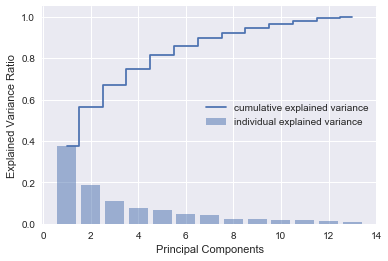

In [10]:
# Explained Variance Ratio and Scree Test
pca_full = PCA(n_components = None)
pca_full.fit(X_train_std)

plt.bar(range(1,14),
       pca_full.explained_variance_ratio_,
       alpha = 0.5,
       align = 'center',
       label = 'individual explained variance')
plt.step(range(1,14),
        np.cumsum(pca_full.explained_variance_ratio_),
        where = 'mid',
        label = 'cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.show()

In [11]:
# Kaiser-Harris Criterion

def kaiser_harris_criterion(cov_mat):
    e_vals, _ = np.linalg.eig(cov_mat)
    return len(e_vals[e_vals > 1])
    
print('Kaiser Harris Criterion: Use {} Principal Components.'.format(kaiser_harris_criterion(np.cov(X_train_std.T))))

Kaiser Harris Criterion: Use 4 Principal Components.


## The Payoff

In [12]:
# Smart P.C.A Logistic Regression vs Naivee Logistic Regression
pca4 = PCA(n_components = 4)
X_train_pca4 = pca4.fit_transform(X_train_std)

logistic.fit(X_train_pca4, Y_train)
print('P.C.A Logistic Regression Training Accuracy: ', logistic.score(X_train_pca4, Y_train))
print('P.C.A Logistic Regression Testing Accuracy: ', logistic.score(pca4.transform(X_test_std), Y_test))

naive.fit(X_train, Y_train)
print('Naive Logistic Regression Training Accuracy: ', naive.score(X_train, Y_train))
print('Naive Logistic Regression Testing Accuracy: ', naive.score(X_test, Y_test))

P.C.A Logistic Regression Training Accuracy:  0.991935483871
P.C.A Logistic Regression Testing Accuracy:  1.0
Naive Logistic Regression Training Accuracy:  0.983870967742
Naive Logistic Regression Testing Accuracy:  0.944444444444


Reference Source: https://github.com/llSourcell/How_to_Make_Data_Amazing/blob/master/demo2.ipynb